<a href="https://colab.research.google.com/github/daigo0927/pwcnet/blob/feature%2Fdataset/test_components.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup environment

## Install dependent libraries

In [1]:
# ! pip install -U tensorflow tensorflow-addons 

## Show directory

In [2]:
# %cd pwcnet/pwcnet
%ls 

__init__.py        flow_vis.py        models.py          pwcdcnet/
__init__.py~       layers.py~         models.py~         unittest.ipynb
__pycache__/       logs_test/         modules.py
datasets.py        losses.py          modules.py~
datasets.py~       losses.py~         package-lock.json


## Import libraries

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from functools import partial

# Create sample data

In [4]:
from flow_vis import flow_to_color, flow_to_quiver, show_image_and_flow

## Visualize the optical flow color palette

fx
 [[-16 -15 -14 ...  13  14  15]
 [-16 -15 -14 ...  13  14  15]
 [-16 -15 -14 ...  13  14  15]
 ...
 [-16 -15 -14 ...  13  14  15]
 [-16 -15 -14 ...  13  14  15]
 [-16 -15 -14 ...  13  14  15]]
fy
 [[-16 -16 -16 ... -16 -16 -16]
 [-15 -15 -15 ... -15 -15 -15]
 [-14 -14 -14 ... -14 -14 -14]
 ...
 [ 13  13  13 ...  13  13  13]
 [ 14  14  14 ...  14  14  14]
 [ 15  15  15 ...  15  15  15]]


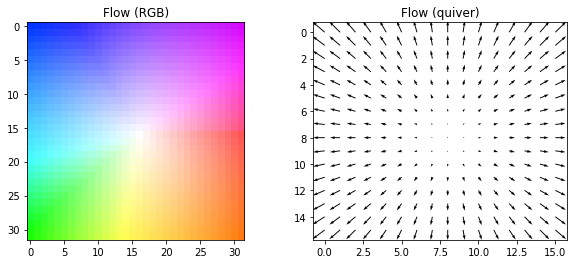

In [5]:
w, h = 32, 32
f = np.arange(-16, 16)
fx = np.tile(f.reshape(1, -1), reps=[h, 1])
fy = np.tile(f.reshape(-1, 1), reps=[1, w])
print('fx\n', fx)
print('fy\n', fy)

flow_sample = np.stack([fx, fy], axis=-1)

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
flow_rgb = flow_to_color(flow_sample)
ax1.set_title('Flow (RGB)')
ax1.imshow(flow_rgb)

ax2 = fig.add_subplot(122)
flow_quiver = flow_to_quiver(flow_sample[::2, ::2])
ax2.set_title('Flow (quiver)')
ax2.quiver(*flow_quiver, angles='xy')
ax2.set_ylim(ax2.get_ylim()[::-1])

plt.show()

## Define pre/post-warp image (cyclic warp)

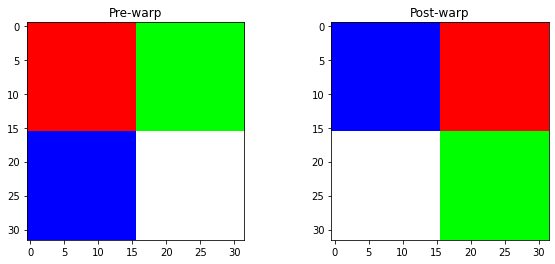

In [6]:
image1_origin = np.zeros((32, 32, 3), dtype=np.uint8)
image1_origin[:16, :16, 0] = 255 # top-left: red
image1_origin[:16, 16:, 1] = 255 # top-right: green
image1_origin[16:, :16, 2] = 255 # bottom-left: blue
image1_origin[16:, 16:, :] = 255 # bottom-right: white

image2_origin = np.zeros((32, 32, 3), dtype=np.uint8)
image2_origin[:16, :16, 2] = 255 # top-left: red
image2_origin[:16, 16:, 0] = 255 # top-right: green
image2_origin[16:, :16, :] = 255 # bottom-left: blue
image2_origin[16:, 16:, 1] = 255 # bottom-right: white

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.set_title('Pre-warp')
ax1.imshow(image1_origin)

ax2 = fig.add_subplot(122)
ax2.set_title('Post-warp')
ax2.imshow(image2_origin)

plt.show()

## Define optical flow (cyclic)

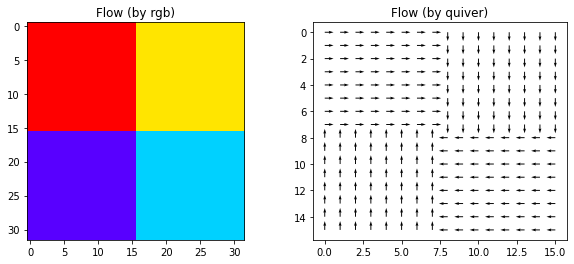

In [7]:
flow_origin = np.zeros((32, 32, 2), dtype=np.float32)
flow_origin[:16, :16, 0] = 16 # red (top-left) -> right
flow_origin[:16, 16:, 1] = 16 # green (top-right) -> bottom
flow_origin[16:, 16:, 0] = -16 # white (bottom-right) -> left
flow_origin[16:, :16, 1] = -16 # blue (bottom-left) -> top

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.set_title('Flow (by rgb)')
ax1.imshow(flow_to_color(flow_origin))

ax2 = fig.add_subplot(122)
ax2.set_title('Flow (by quiver)')
ax2.quiver(*flow_to_quiver(flow_origin[::2, ::2]), angles='xy')
ax2.set_ylim(ax2.get_ylim()[::-1])

plt.show()

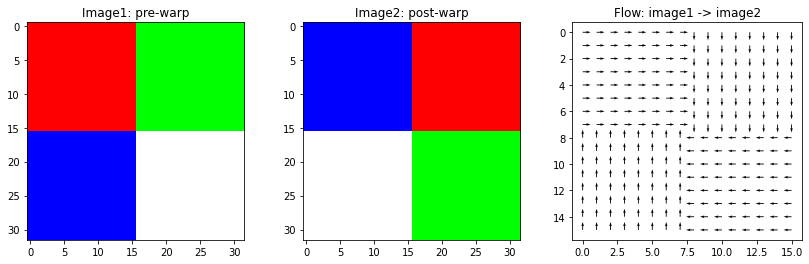

In [8]:
show_image_and_flow(image1_origin, image2_origin, flow_origin[::2, ::2], as_quiver=True)

# Validate preprocessing function

In [9]:
from datasets import (
    scaling,
    random_crop,
    random_horizontal_flip, hflip,
    random_vertical_flip, vflip,
)

## Prepare initial tf.data.Dataset object

In [10]:
images1_origin = [image1_origin for i in range(10)]
images2_origin = [image2_origin for i in range(10)]
flows_origin = [flow_origin for i in range(10)]
dataset = tf.data.Dataset.from_tensor_slices((images1_origin, images2_origin, flows_origin))

## Run preprocessings

### Normalization

In [11]:
ds = dataset.map(scaling)
ds = ds.map(lambda image1, image2, flow:
           [tf.cast(image1, tf.float32), tf.cast(image2, tf.float32), flow])
im1, im2, flo = list(ds.as_numpy_iterator())[0]

print(f'Original stats: {image1_origin.max(), image2_origin.max(), flow_origin.max()}')
print(f'Processed stats: {im1.max(), im2.max(), flo.max()}')

Original stats: (255, 255, 16.0)
Processed stats: (1.0, 1.0, 16.0)


### Random crop

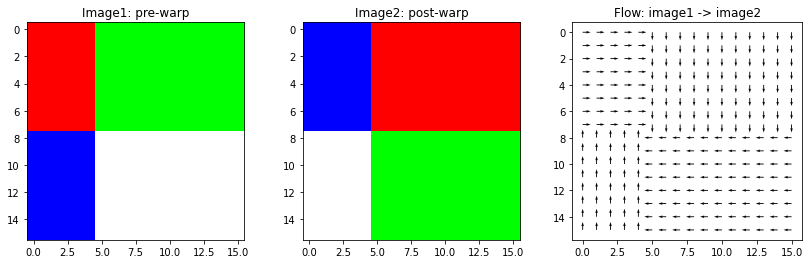

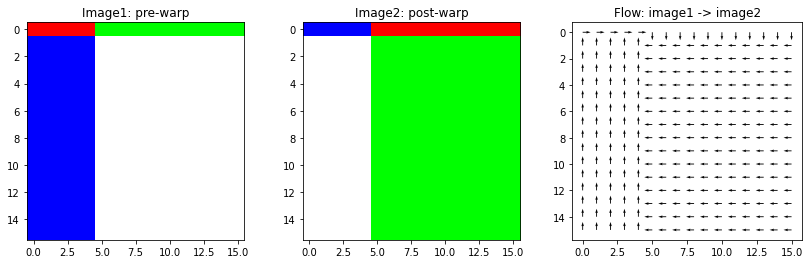

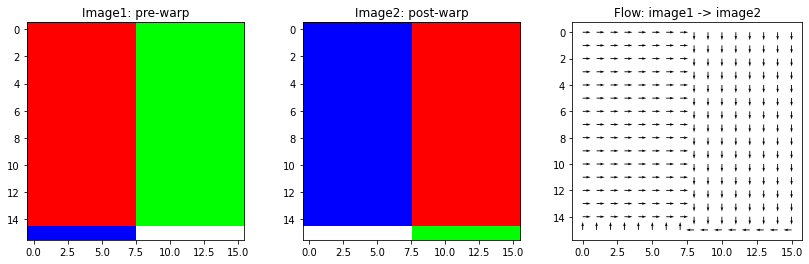

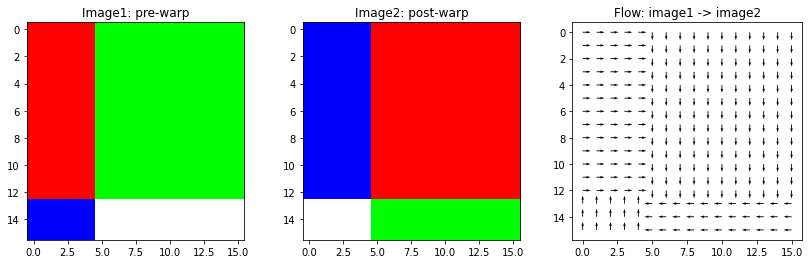

In [12]:
target_size = (16, 16)
ds_crop = ds.map(partial(random_crop, target_size=target_size))

for image1, image2, flow in ds_crop.take(4):
    show_image_and_flow(image1, image2, flow, as_quiver=True)

### Horizontal flip

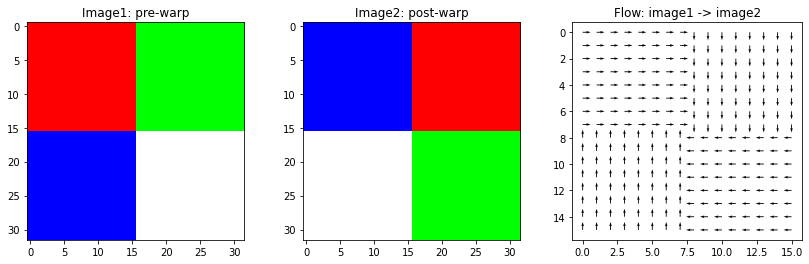

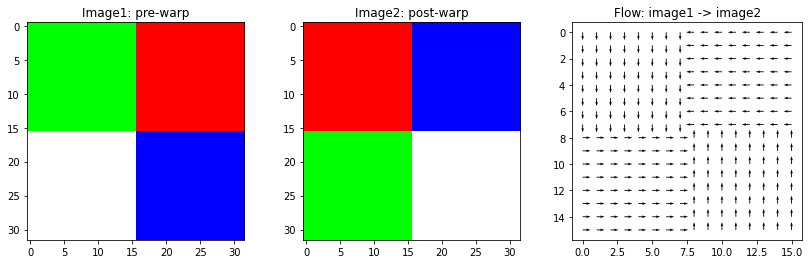

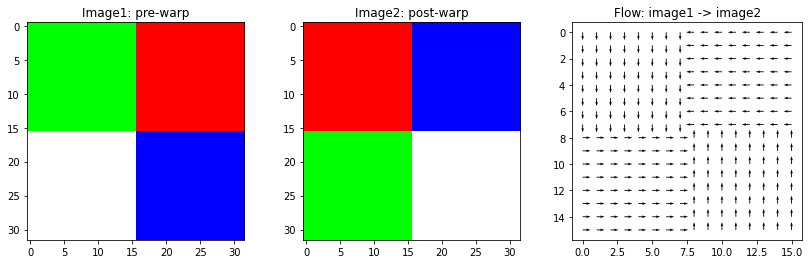

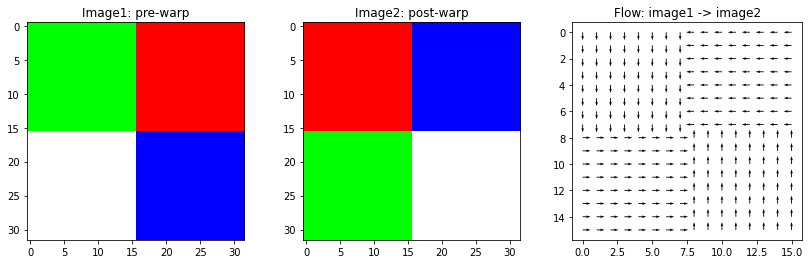

In [13]:
ds_hflip = ds.map(random_horizontal_flip)

for image1, image2, flow in ds_hflip.take(4):
    show_image_and_flow(image1, image2, flow[::2, ::2], as_quiver=True)

### Vertical flip

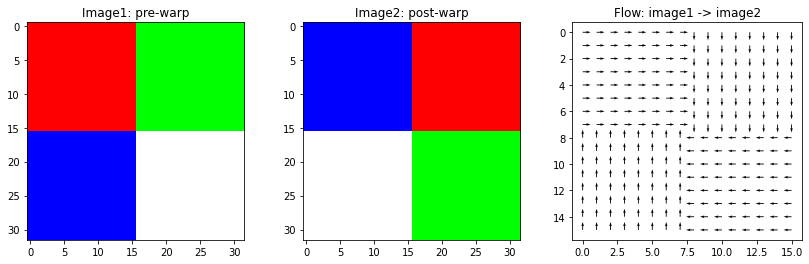

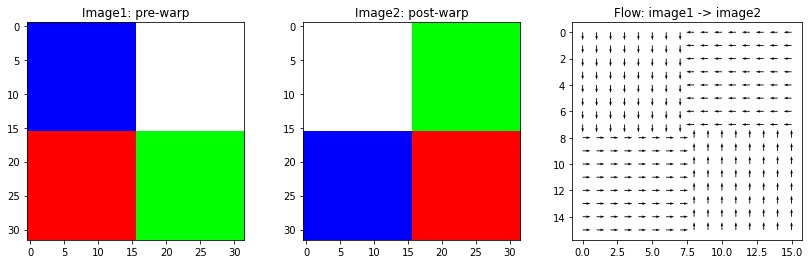

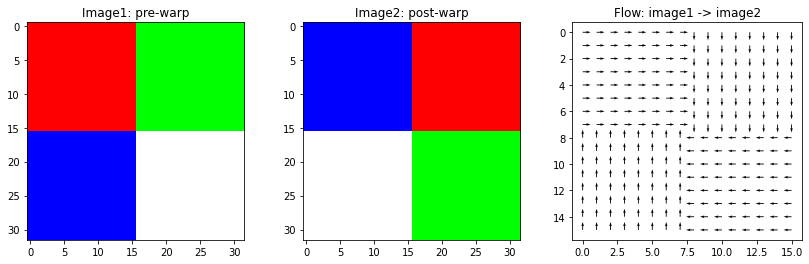

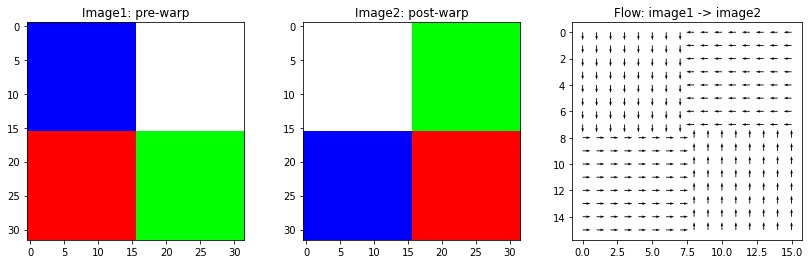

In [14]:
ds_vflip = ds.map(random_vertical_flip)

for image1, image2, flow in ds_vflip.take(4):
    show_image_and_flow(image1, image2, flow[::2, ::2], as_quiver=True)

## MPI-SIntel dataset

In [15]:
from datasets import build_sintel_dataset

In [16]:
# Specify appropriate directory
sintel_path = '/Users/Daigo/Data/MPI-Sintel-complete'
dataset, samples = build_sintel_dataset(sintel_path, mode='clean', with_files=True)
samples[:10]

[('/Users/Daigo/Data/MPI-Sintel-complete/training/clean/alley_1/frame_0001.png',
  '/Users/Daigo/Data/MPI-Sintel-complete/training/clean/alley_1/frame_0002.png',
  '/Users/Daigo/Data/MPI-Sintel-complete/training/flow/alley_1/frame_0001.flo'),
 ('/Users/Daigo/Data/MPI-Sintel-complete/training/clean/alley_1/frame_0002.png',
  '/Users/Daigo/Data/MPI-Sintel-complete/training/clean/alley_1/frame_0003.png',
  '/Users/Daigo/Data/MPI-Sintel-complete/training/flow/alley_1/frame_0002.flo'),
 ('/Users/Daigo/Data/MPI-Sintel-complete/training/clean/alley_1/frame_0003.png',
  '/Users/Daigo/Data/MPI-Sintel-complete/training/clean/alley_1/frame_0004.png',
  '/Users/Daigo/Data/MPI-Sintel-complete/training/flow/alley_1/frame_0003.flo'),
 ('/Users/Daigo/Data/MPI-Sintel-complete/training/clean/alley_1/frame_0004.png',
  '/Users/Daigo/Data/MPI-Sintel-complete/training/clean/alley_1/frame_0005.png',
  '/Users/Daigo/Data/MPI-Sintel-complete/training/flow/alley_1/frame_0004.flo'),
 ('/Users/Daigo/Data/MPI-Sin

1.0 1.0 3.8958855


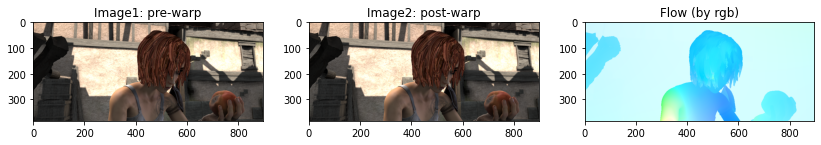

1.0 1.0 4.3650546


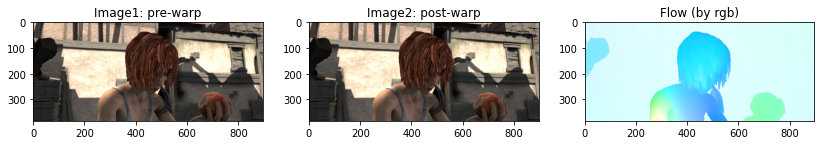

1.0 1.0 4.7616463


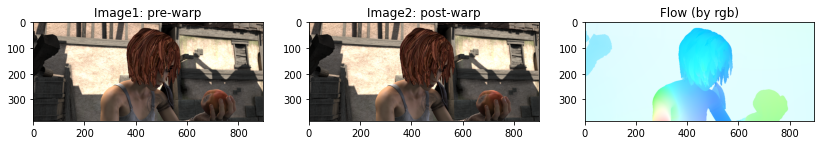

1.0 1.0 5.0850735


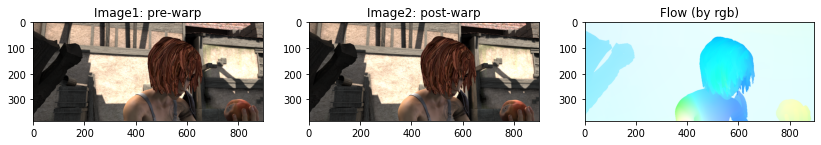

1.0 1.0 5.213102


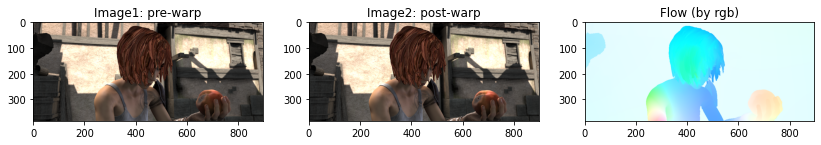

1.0 1.0 5.956953


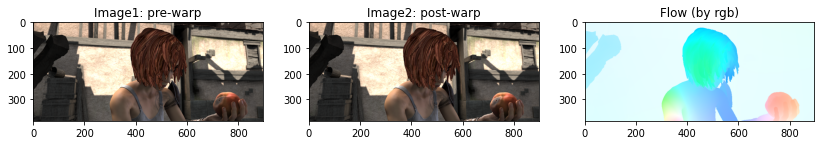

1.0 1.0 9.711645


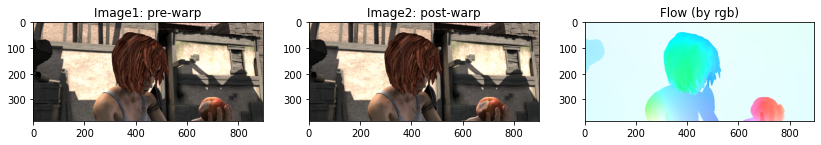

1.0 1.0 12.75259


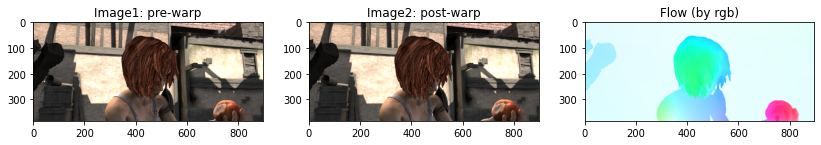

1.0 1.0 14.065284


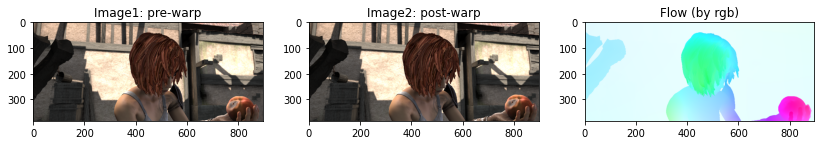

1.0 1.0 13.580682


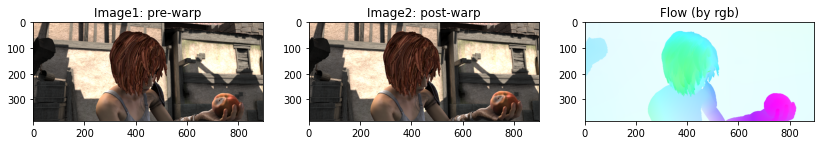

In [17]:
target_size = (384, 896)
ds_sintel = dataset.map(scaling).map(partial(random_crop, target_size=target_size))

for image1, image2, flow in ds_sintel.take(10):
    print(image1.numpy().max(), image2.numpy().max(), flow.numpy().max())
    show_image_and_flow(image1, image2, flow)

# Validate modules and model

In [24]:
from modules import (
    nearest_warp, bilinear_warp, dense_warp, cost_volume
)
from models import PWCNet, PWCDCNet

## Warping function

In [19]:
x = list(ds.batch(1))[0]
x[0].shape

TensorShape([1, 32, 32, 3])

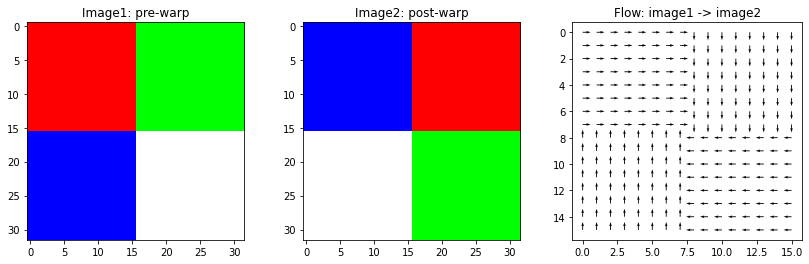

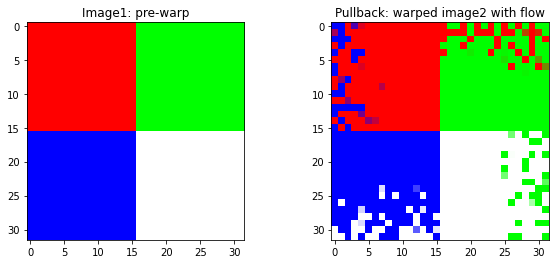

In [20]:
interpolation = 'bilinear' # 'nearest'
noise = tf.random.uniform((1, h, w, 2), 0.5, 1.5) # Only for validation 

image1, image2, flow = list(ds.batch(1))[0]
show_image_and_flow(image1.numpy()[0], image2.numpy()[0], flow.numpy()[0, ::2, ::2], as_quiver=True)

pullback = dense_warp(image2, flow*noise, interpolation=interpolation)

fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(121)
ax1.set_title('Image1: pre-warp')
ax1.imshow(image1.numpy()[0])

ax2 = fig.add_subplot(122)
ax2.set_title('Pullback: warped image2 with flow')
ax2.imshow(pullback.numpy()[0])
plt.show()

## CostVolume module

In [21]:
ones = tf.ones((1, 16, 16, 1))
ones2 = tf.ones((1, 16, 16, 1))
ones[0, :, :, 0]

<tf.Tensor: shape=(16, 16), dtype=float32, numpy=
array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
 

In [22]:
# cv_layer = tfa.layers.CorrelationCost(kernel_size=1,
#                                      max_displacement=4,
#                                      stride_1=1,
#                                      stride_2=1,
#                                      pad=8,
#                                      data_format='channels_last')
# cost = cv_layer([ones, ones2])
# print(np.round(cost[0, :, :, -1].numpy(), 1))
# cost.shape

In [25]:
cost = cost_volume(ones, ones2, search_range=4)
cost[0, :, :, 0].numpy()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,

## PWCNet model

In [27]:
images_1 = tf.random.normal((1, 384, 448, 3))
images_2 = tf.random.normal((1, 384, 448, 3))

model = PWCNet()
flows_pyramid, flows_pred = model([images_1, images_2])
for flow_pred in flows_pyramid:
    print(flow_pred.shape)

(1, 96, 112, 2)
(1, 48, 56, 2)
(1, 24, 28, 2)
(1, 12, 14, 2)
(1, 6, 7, 2)


In [28]:
model.summary()

Model: "pwc_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_24 (Sequential)   multiple                  2768      
_________________________________________________________________
sequential_25 (Sequential)   multiple                  13888     
_________________________________________________________________
sequential_26 (Sequential)   multiple                  55424     
_________________________________________________________________
sequential_27 (Sequential)   multiple                  138432    
_________________________________________________________________
sequential_28 (Sequential)   multiple                  258304    
_________________________________________________________________
sequential_29 (Sequential)   multiple                  553344    
_________________________________________________________________
flow_block_10 (FlowBlock)    multiple                  42

### PWCDCNet

In [33]:
model2 = PWCDCNet()
flows_pyramid = model2([images_1, images_2], training=True)
for flow_pred in flows_pyramid:
    print(flow_pred.shape)

(1, 96, 112, 2)
(1, 48, 56, 2)
(1, 24, 28, 2)
(1, 12, 14, 2)
(1, 6, 7, 2)


In [31]:
model2.summary()

Model: "pwcdc_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_43 (Sequential)   multiple                  5088      
_________________________________________________________________
sequential_44 (Sequential)   multiple                  23136     
_________________________________________________________________
sequential_45 (Sequential)   multiple                  92352     
_________________________________________________________________
sequential_46 (Sequential)   multiple                  221472    
_________________________________________________________________
sequential_47 (Sequential)   multiple                  405888    
_________________________________________________________________
sequential_48 (Sequential)   multiple                  885312    
_________________________________________________________________
dense_flow_block_5 (DenseFlo multiple                  

ValueError: You tried to call `count_params` on up_sampling2d_4, but the layer isn't built. You can build it manually via: `up_sampling2d_4.build(batch_input_shape)`.

In [32]:
tf.image.resize?

Signature:
tf.image.resize(
    images,
    size,
    method='bilinear',
    preserve_aspect_ratio=False,
    antialias=False,
    name=None,
)
Docstring:
Resize `images` to `size` using the specified `method`.

Resized images will be distorted if their original aspect ratio is not
the same as `size`.  To avoid distortions see
`tf.image.resize_with_pad`.

>>> image = tf.constant([
...  [1,0,0,0,0],
...  [0,1,0,0,0],
...  [0,0,1,0,0],
...  [0,0,0,1,0],
...  [0,0,0,0,1],
... ])
>>> # Add "batch" and "channels" dimensions
>>> image = image[tf.newaxis, ..., tf.newaxis]
>>> image.shape.as_list()  # [batch, height, width, channels]
[1, 5, 5, 1]
>>> tf.image.resize(image, [3,5])[0,...,0].numpy()
array([[0.6666667, 0.3333333, 0.       , 0.       , 0.       ],
       [0.       , 0.       , 1.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.3333335, 0.6666665]],
      dtype=float32)

It works equally well with a single image instead of a batch of images:

>>> tf.image.r

# Loss functions

In [ ]:
from losses import (
    l1_loss, l2_loss, end_point_error, multiscale_loss, multirobust_loss
)

In [ ]:
flow_true = tf.zeros((1, 32, 32, 2))
flow_pred = tf.ones((1, 32, 32, 2))

flow_pred_pyramid = [
    tf.ones((1, 32, 32, 2)),
    tf.ones((1, 16, 16, 2))/2,
    tf.ones((1, 8, 8, 2))/4,
    tf.ones((1, 4, 4, 2))/8,
    tf.ones((1, 2, 2, 2))/16
]

In [ ]:
l1 = l1_loss(flow_true, flow_pred)
print(f'L1 loss: {l1}')

l2 = l2_loss(flow_true, flow_pred)
print(f'L2 loss: {l2}')

epe = end_point_error(flow_true, flow_pred)
print(f'End point error: {epe}')

ms = multiscale_loss(flow_true, flow_pred_pyramid)
print(f'Multiscale loss: {ms}')

mr = multirobust_loss(flow_true, flow_pred_pyramid)
print(f'Multirobust loss: {mr}')